In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from DA_PoC.dynamicalsystems.lorenz63 import Lorenz63Model
from DA_PoC.filters.EnKF import EnKF
%matplotlib inline

rng = np.random.default_rng(seed=1994)

/mnt/c/Users/a846735/DA_sandbox/notebooks/../DA_PoC/filters/EnKF.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
Nensemble = 100
period_assim = 1
Nsteps = 500
state_dimension= 3
inflation_factor = 1.01

In [3]:
# Properties of the model
dt = 0.02
Lorenz63Model.dt = dt
H = np.atleast_2d([[1, 0, 0], [0, 1, 0]])
sigobs = 5
R = sigobs * np.atleast_2d([[1, 0], [0, 1]])

In [4]:
truth = Lorenz63Model()
truth.set_initial_state(-5000 * dt, np.array([0, 1, 0]))
truth.forward(5000)  # Burn-in period
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + rng.randn(1) * sigobs
    return truth.t[-1], y
initial_state = truth.state_vector[:, -1]

In [6]:
enkf = EnKF(state_dimension, Nensemble, R, inflation_factor, rng)
enkf.H = H
enkf.set_forwardmodel(lambda x: Lorenz63Model.integrate(0, x, period_assim)[1][:, -1])
enkf.generate_ensemble(mean=initial_state, cov=np.eye(state_dimension), rng=rng)


dEnKF = enkf.run(Nsteps, get_obs=generate_observations)

SyntaxError: positional argument follows keyword argument (3045096720.py, line 4)

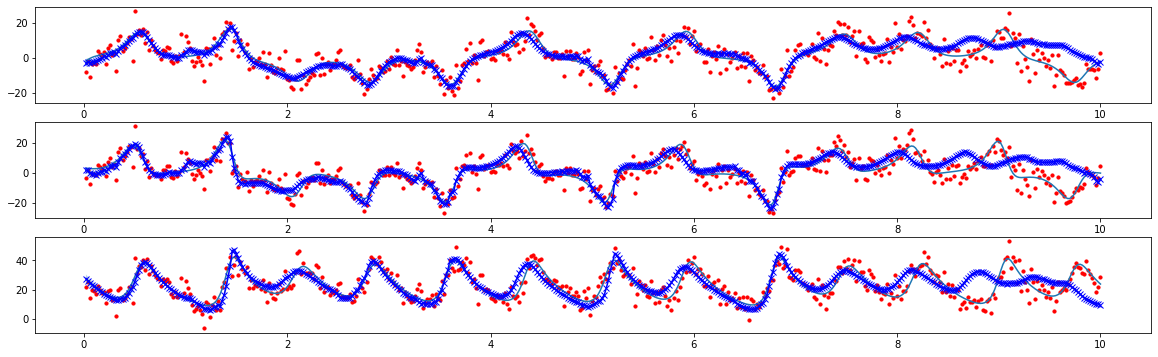

In [ ]:
xabar = np.array(dEnKF["ensemble_a"]).mean(-1)
xa_std = np.array(dEnKF["ensemble_a"]).std(-1)
xbarpstd = xabar +  3 * xa_std
xbarmstd = xabar - 3*xa_std
obs_ = np.array(dEnKF["observations"])
plt.figure(figsize=(20, 6))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[5001:], truth.state_vector[i, 5001:])
    plt.scatter(dEnKF["time"], obs_[:, i], marker="o", c="red", s=10)
    plt.plot(dEnKF["time"], xabar[:, i], "x-", color="blue")
    # plt.vlines(dEnKF["time"], xabar[:, i], obs_[:, i])
    plt.fill_between(dEnKF["time"], xbarmstd[:, i], xbarpstd[:, i], alpha=0.3)
plt.show()

In [ ]:
obs_.shape

(500, 3)